In [1]:
import numpy as np
import pandas as pd
import json
from typing import Tuple
from PIL import Image
from torchvision import transforms
from utils import Normalize
from torchvision.models import resnet50
import torch
import torch.nn as nn
from target_model import TargetModel
from classify_model import LeNet5
import warnings
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from magma import Magma
from PGD_attack import PGD
from art.attacks.evasion import SaliencyMapMethod
from art.estimators.classification import PyTorchClassifier

In [2]:
model = LeNet5()
model.load_state_dict(torch.load("model_1.pth"))
model.eval()

LeNet5(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
  )
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

In [3]:
train = datasets.MNIST(
    root="dataset/",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()]),
)

In [4]:
target_model = TargetModel(model)

In [5]:
select_idx = 0

In [6]:
genetic_attack = Magma(500, train[select_idx][0].shape, 5000)
genetic_attack_noise = genetic_attack.attack(train[select_idx][0], target_model)

5000
500
torch.Size([1, 32, 32])
Evolution:  100
Evolution:  100 Fittest:  0.03562005236744881
Evolution:  200
Evolution:  200 Fittest:  0.04061829298734665
Evolution:  300
Evolution:  300 Fittest:  0.04061829298734665
Evolution:  400
Evolution:  400 Fittest:  0.042300271242856985
Evolution:  500
Evolution:  500 Fittest:  0.04929554015398026
Evolution:  600
Evolution:  600 Fittest:  0.04929554015398026
Evolution:  700
Evolution:  700 Fittest:  0.04929554015398026
Evolution:  800
Evolution:  800 Fittest:  0.04929554015398026
Evolution:  900
Evolution:  900 Fittest:  0.04929554015398026
Evolution:  1000
Evolution:  1000 Fittest:  0.04929554015398026
Evolution:  1100
Evolution:  1100 Fittest:  0.04929554015398026
Evolution:  1200
Evolution:  1200 Fittest:  0.04929554015398026
Evolution:  1300
Evolution:  1300 Fittest:  0.04929554015398026
Evolution:  1400
Evolution:  1400 Fittest:  0.04929554015398026
Evolution:  1500
Evolution:  1500 Fittest:  0.04929554015398026
Evolution:  1600
Evoluti

In [8]:
epsilon = 0.05
iterations = 50
alpha = 2./255

In [9]:
print(train[select_idx][1])

5


In [10]:
pgd_attack = PGD(model, train[select_idx][0].unsqueeze(0), torch.tensor(train[select_idx][1]).unsqueeze(0), epsilon, iterations, alpha)

In [11]:
classifier = PyTorchClassifier(
    model=model,
    loss=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    input_shape=(1, 32, 32),
    nb_classes=10,
)

In [51]:
saliency_attack = SaliencyMapMethod(classifier, theta=0.1, gamma=1.0, batch_size=1, verbose=True)
saliency_attack_res = saliency_attack.generate(x=train[select_idx][0].unsqueeze(0).detach().numpy(), eps=epsilon)

JSMA: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


In [59]:
# print(saliency_attack_res.min())
saliency_attack_res = np.clip(saliency_attack_res, 0, 1)

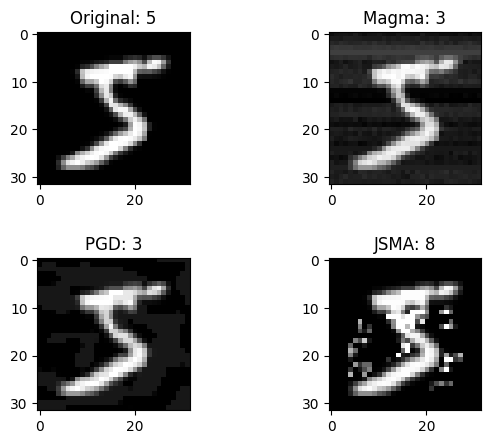

In [60]:
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
ax.imshow(train[select_idx][0].squeeze(0), cmap="gray")
ax.set_title("Original: " + str(target_model.predict(train[0][0])))
ax = fig.add_subplot(2, 2, 2)
ax.imshow((train[select_idx][0] + genetic_attack_noise).squeeze(0), cmap="gray")
ax.set_title(
    "Magma: "
    + str(target_model.predict(train[select_idx][0] + genetic_attack_noise))
)
ax = fig.add_subplot(2, 2, 3)
ax.imshow(pgd_attack.detach().numpy()[0].squeeze(0), cmap="gray")
ax.set_title("PGD: " + str(target_model.predict(pgd_attack[0])))
ax = fig.add_subplot(2, 2, 4)
ax.imshow(saliency_attack_res[0].squeeze(0), cmap="gray")
ax.set_title("JSMA: " + str(target_model.predict(torch.tensor(saliency_attack_res[0]))))
fig.tight_layout(pad=2.0)
plt.show()

In [61]:
magma_noise = (genetic_attack_noise.squeeze(0) * 255).detach().numpy()
magma_noise = magma_noise + abs(magma_noise.min())
magma_noise = magma_noise.astype(np.uint8)
# magma_noise = np.clip(magma_noise, 0, 255)
# magma_noise = np.clip(magma_noise, 0, 255).detach().numpy().astype(np.uint8)
print(magma_noise.min())
print(magma_noise.max())

pgd_noise = (pgd_attack - train[select_idx][0]).detach().numpy()[0].squeeze(0) * 255
pgd_noise = pgd_noise + abs(pgd_noise.min())
pgd_noise = pgd_noise.astype(np.uint8)
# pgd_noise = np.clip(pgd_noise, 0, 255)
# pgd_noise = np.clip(pgd_noise, 0, 255).astype(np.uint8)
print(pgd_noise.min())
print(pgd_noise.max())


saliency_noise = (saliency_attack_res[0] - (train[select_idx][0].detach().numpy())).squeeze(0) * 255
saliency_noise = saliency_noise + abs(saliency_noise.min())
saliency_noise = saliency_noise.astype(np.uint8)
# saliency_noise = np.clip(saliency_noise, 0, 255)
# saliency_noise = np.clip(saliency_noise, 0, 255).astype(np.uint8)
print(saliency_noise.min())
print(saliency_noise.max())

0
75
0
25
0
255


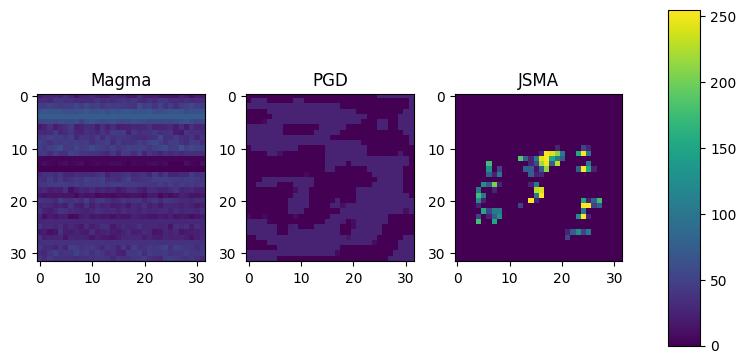

In [62]:
fig = plt.figure()
ax = fig.add_subplot(1, 3, 1)
im = ax.imshow(magma_noise, vmin=0, vmax=255)
ax.set_title("Magma")
ax = fig.add_subplot(1, 3, 2)
im = ax.imshow(pgd_noise, vmin=0, vmax=255)
ax.set_title("PGD")
ax = fig.add_subplot(1, 3, 3)
im = ax.imshow(saliency_noise, vmin=0, vmax=255)
ax.set_title("JSMA")
# ax.imshow((train[select_idx][0] + genetic_attack_noise).squeeze(0), cmap="gray")
# ax.set_title(
#     "Magma: "
#     + str(target_model.predict(train[select_idx][0] + genetic_attack_noise))
# )
# ax = fig.add_subplot(2, 2, 3)
# ax.imshow(pgd_attack.detach().numpy()[0].squeeze(0), cmap="gray")
# ax.set_title("PGD: " + str(target_model.predict(pgd_attack[0])))
# ax = fig.add_subplot(2, 2, 4)
# ax.imshow(salency_attack_res[0].squeeze(0), cmap="gray")
# ax.set_title("PGD: " + str(target_model.predict(torch.tensor(salency_attack_res[0]))))
fig.subplots_adjust(right=0.6)
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.tight_layout(pad=1.0)
plt.show()

In [64]:
pred_base_logits = target_model.predict_logits(train[select_idx][0])
max_norm = np.linalg.norm(np.full(fill_value=1, shape=train[select_idx][0].shape))
beta = 0.5

print("Magma fitness: " + str(genetic_attack.fitness_untargetted(genetic_attack_noise, train[select_idx][0], target_model)))

pgd_logits = model(pgd_attack[0].unsqueeze(0))[0].detach().numpy()
# print(pred_base_logits)
# print(pgd_logits)
pgd_abs_diff = np.abs(pgd_logits - pred_base_logits)
pgd_missclassification_score = np.sum(pgd_abs_diff) / len(pgd_abs_diff)
pgd_poison_magnitude = np.linalg.norm((pgd_attack[0].unsqueeze(0) - train[select_idx][0]).detach().numpy()) / max_norm
pgd_fitness = (beta * pgd_missclassification_score) - (
            (1 - beta) * pgd_poison_magnitude
        )

print("PGD Fitness: " + str(pgd_fitness))

saliency_logits = model(torch.tensor(saliency_attack_res[0]).unsqueeze(0))[0].detach().numpy()
saliency_abs_diff = np.abs(saliency_logits - pred_base_logits)
saliency_missclassification_score = np.sum(saliency_abs_diff) / len(pgd_abs_diff)
saliency_poison_magnitude = np.linalg.norm((saliency_attack_res - train[select_idx][0].detach().numpy())) / max_norm
saliency_fitness = (beta * saliency_missclassification_score) - (
            (1 - beta) * saliency_poison_magnitude
        )
print("Saliency Fitness: " + str(saliency_fitness))


Magma fitness: 0.04929554015398026
PGD Fitness: 0.07421887293457985
Saliency Fitness: 0.006005766987800601
